In [7]:
import kagglehub

# Downloading the latest version of the dataset.
path = kagglehub.dataset_download("abdulhasibuddin/uc-merced-land-use-dataset")

print("Path to dataset files:", path)

/Users/farazahmed/Documents/Python projects/tf_gpu_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/farazahmed/.cache/kagglehub/datasets/abdulhasibuddin/uc-merced-land-use-dataset/versions/1


In [8]:
import shutil

# Setting source and destination paths
source = path
destination = '/Users/farazahmed/Documents/Python projects/COMP534_assignment2'


# Copying folder or file
shutil.copytree(source, f'{destination}/UCMerced_LandUse', dirs_exist_ok=True)


'/Users/farazahmed/Documents/Python projects/COMP534_assignment2/UCMerced_LandUse'

In [18]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# TensorFlow / Keras (for deep learning pipeline)
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Torch and torchvision (optional, if you're mixing PyTorch tasks too)
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader


  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


Data Augmentation

In [19]:
import os
import shutil
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
import random

# Fix seed for reproducibility
np.random.seed(42)
random.seed(42)

# --- STEP 1: Converting all .tif images to .jpg ---
input_dataset_path = '/Users/farazahmed/Documents/Python projects/COMP534_assignment2/UCMerced_LandUse/UCMerced_LandUse/Images'  # .tif dataset
converted_dataset_path = input_dataset_path + '_jpg'

os.makedirs(converted_dataset_path, exist_ok=True)

for class_name in os.listdir(input_dataset_path):
    class_dir = os.path.join(input_dataset_path, class_name)
    if not os.path.isdir(class_dir): continue

    output_class_dir = os.path.join(converted_dataset_path, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    for filename in os.listdir(class_dir):
        if filename.lower().endswith('.tif'):
            src_path = os.path.join(class_dir, filename)
            img = Image.open(src_path).convert('RGB')

            base_name = os.path.splitext(filename)[0]
            dst_path = os.path.join(output_class_dir, f'{base_name}.jpg')
            img.save(dst_path)

print("Converted all .tif to .jpg.")

# --- STEP 2: Splitting into trainval / test ---
output_dataset_path = os.path.join(converted_dataset_path, 'augmented_dataset')
trainval_path = os.path.join(output_dataset_path, 'trainval')
test_path = os.path.join(output_dataset_path, 'test')

os.makedirs(trainval_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_name in os.listdir(converted_dataset_path):
    class_dir = os.path.join(converted_dataset_path, class_name)
    if not os.path.isdir(class_dir): continue
    if class_name == 'augmented_dataset': continue 

    images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
    trainval_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    trainval_class_dir = os.path.join(trainval_path, class_name)
    test_class_dir = os.path.join(test_path, class_name)
    os.makedirs(trainval_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

    for img in trainval_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(trainval_class_dir, img))

print("Split into trainval/test sets.")

# --- STEP 3: Augmenting only trainval images ---
augmentation_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
]

target_count = 500

for class_name in os.listdir(trainval_path):
    class_dir = os.path.join(trainval_path, class_name)
    if not os.path.isdir(class_dir): continue

    original_images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
    if not original_images:
        print(f"Warning: No images in {class_dir}")
        continue

    attempts = 0
    max_attempts = 1000

    while len(os.listdir(class_dir)) < target_count and attempts < max_attempts:
        try:
            src_img_name = random.choice(original_images)
            src_path = os.path.join(class_dir, src_img_name)
            img = Image.open(src_path)

            transform = random.choice(augmentation_transforms)
            augmented_img = transform(img)

            base_name = os.path.splitext(src_img_name)[0]
            new_img_name = f"{base_name}_aug_{len(os.listdir(class_dir))}.jpg"
            dst_path = os.path.join(class_dir, new_img_name)
            augmented_img.save(dst_path)

            attempts = 0
        except Exception as e:
            print(f"Error augmenting {src_img_name}: {e}")
            attempts += 1

    print(f"{class_name}: {len(os.listdir(class_dir))} images after augmentation")

print("Augmentation complete for trainval set.")



Converted all .tif to .jpg.
Split into trainval/test sets.
forest: 500 images after augmentation
buildings: 500 images after augmentation
river: 500 images after augmentation
mobilehomepark: 500 images after augmentation
harbor: 500 images after augmentation
golfcourse: 500 images after augmentation
agricultural: 500 images after augmentation
runway: 500 images after augmentation
baseballdiamond: 500 images after augmentation
overpass: 500 images after augmentation
chaparral: 500 images after augmentation
tenniscourt: 500 images after augmentation
intersection: 500 images after augmentation
airplane: 500 images after augmentation
parkinglot: 500 images after augmentation
sparseresidential: 500 images after augmentation
mediumresidential: 500 images after augmentation
denseresidential: 500 images after augmentation
beach: 500 images after augmentation
freeway: 500 images after augmentation
storagetanks: 500 images after augmentation
Augmentation complete for trainval set.


Available classes: ['forest', 'buildings', 'river', 'mobilehomepark', 'harbor', 'golfcourse', 'agricultural', 'runway', 'baseballdiamond', 'overpass', 'chaparral', 'tenniscourt', 'intersection', 'airplane', 'parkinglot', 'sparseresidential', 'mediumresidential', 'denseresidential', 'beach', 'freeway', 'storagetanks']


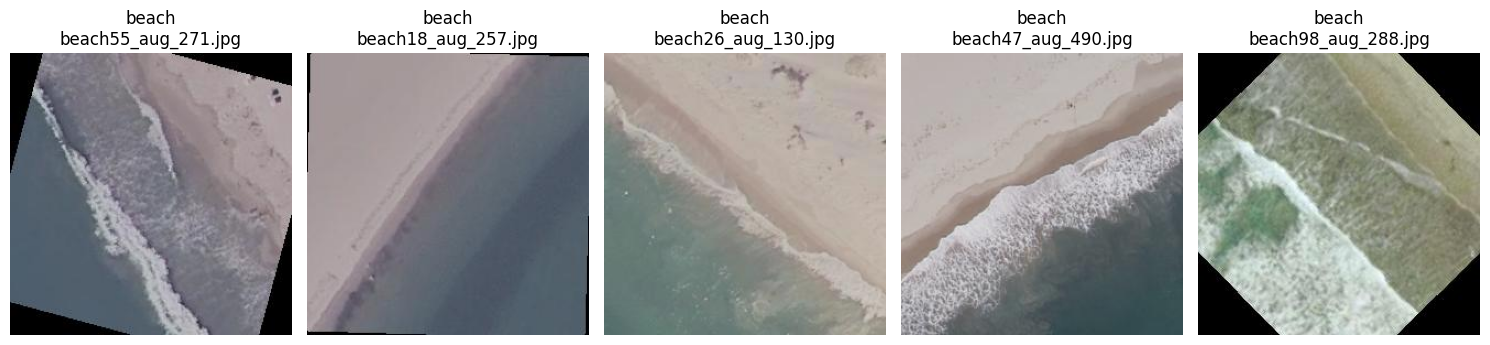

In [20]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def visualize_augmented_images(dataset_path, class_name=None, num_examples=4):
    """
    Visualize augmented images from the dataset

    Args:
    - dataset_path (str): Path to the augmented dataset/trainval
    - class_name (str, optional): Specific class to visualize. If None, picks a random one.
    - num_examples (int): Number of images to display
    """
    # Listing available classes
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    if not classes:
        print("No classes found in the dataset!")
        return

    if class_name is None:
        class_name = random.choice(classes)

    # Full path to class
    class_path = os.path.join(dataset_path, class_name)

    # Getting image files
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    if len(image_files) == 0:
        print(f"No images found in class '{class_name}'")
        return

    # Limit to available number of images
    num_examples = min(num_examples, len(image_files))

    # Selecting random images
    selected_images = random.sample(image_files, num_examples)

    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        img_path = os.path.join(class_path, image_name)
        img = Image.open(img_path)

        plt.subplot(1, num_examples, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{image_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Defining the actual path to trainval set
trainval_path = os.path.join(input_dataset_path + '_jpg', 'augmented_dataset', 'trainval')

# Checking available classes
available_classes = os.listdir(trainval_path)
print("Available classes:", available_classes)

# Visualizing a class (e.g., 'beach')
visualize_augmented_images(trainval_path, class_name='beach', num_examples=5)



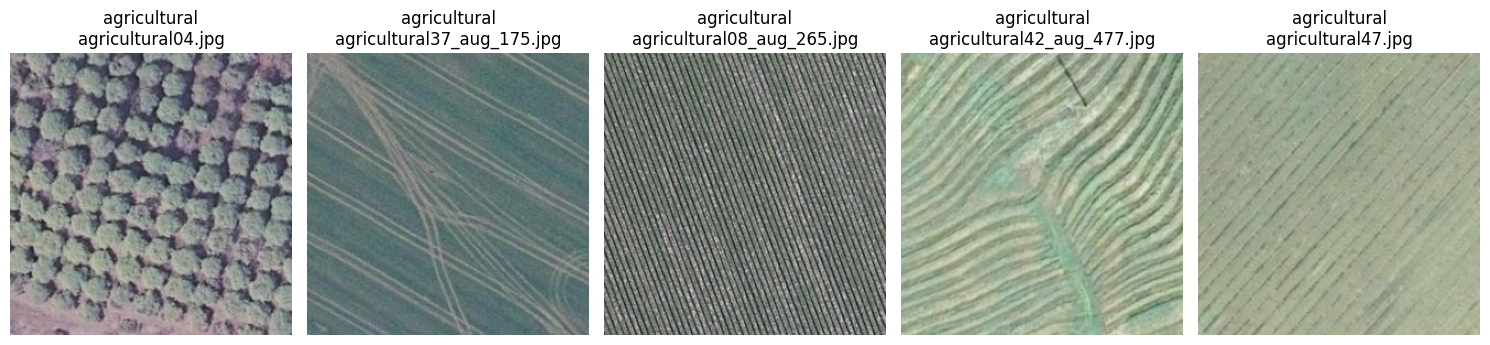

In [23]:
visualize_augmented_images('/Users/deepanshudawande/Downloads/COMP534_Assignment2/UCMerced_LandUse/UCMerced_LandUse/Images_jpg/augmented_dataset/trainval', 'agricultural', 5)


In [21]:
folder_path = trainval_path + '/beach'
num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])

print(f"Number of images in 'beach': {num_images}")

Number of images in 'beach': 500


In [22]:
test_path


'/Users/farazahmed/Documents/Python projects/COMP534_assignment2/UCMerced_LandUse/UCMerced_LandUse/Images_jpg/augmented_dataset/test'

In [23]:
image_size = (224, 224)
batch_size = 32


# Loading training/validation dataset from 'trainval' directory with 80-20 split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainval_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=42,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    trainval_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=42,
    label_mode='categorical'
)

# Loading test dataset from 'test' directory (no validation split needed)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Important for consistent evaluation
    label_mode='categorical'
)

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Applying normalization to all datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 10500 files belonging to 21 classes.
Using 8400 files for training.


2025-04-02 19:59:19.640780: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-02 19:59:19.640816: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-02 19:59:19.640823: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-02 19:59:19.640851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-02 19:59:19.640861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 10500 files belonging to 21 classes.
Using 2100 files for validation.
Found 420 files belonging to 21 classes.


## Neural networks

## Custom Model

In [24]:
custom_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Conv Block 1
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 4
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 5
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Conv Block 6
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(21, activation='softmax')
])


In [25]:
custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │        10,77

 Total params: 3,947,381 (15.06 MB)

 Trainable params: 3,945,365 (15.05 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [26]:
custom_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Epoch 1/200


2025-04-02 19:59:41.344563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2900 - loss: 4.9231
Epoch 1: val_loss improved from inf to 14.70219, saving model to best_custom_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.2903 - loss: 4.9205 - val_accuracy: 0.0424 - val_loss: 14.7022 - learning_rate: 1.0000e-04
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5671 - loss: 2.7440
Epoch 2: val_loss improved from 14.70219 to 2.13734, saving model to best_custom_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.5672 - loss: 2.7433 - val_accuracy: 0.6114 - val_loss: 2.1373 - learning_rate: 1.0000e-04
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7070 - loss: 1.7919
Epoch 3: val_loss improved from 2.13734 to 0.42614, saving model to best_custom_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.7071 - loss: 1.7914 - val_accuracy: 0.8867 - val_loss: 0.4261 - learning_rate: 1.0000e-04
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7956 - loss: 1.1001
Epoch 4: val_loss did not improve from 0.42614
263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.7957 - loss: 1.0999 - val_accuracy: 0.8457 - val_loss: 0.8096 - learning_rate: 1.0000e-04
Epoch 5/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8715 - loss: 0.6804
Epoch 5: val_loss improved from 0.42614 to 0.33916, saving model to best_custom_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.8715 - loss: 0.6802 - val_accuracy: 0.9267 - val_loss: 0.3392 - learning_rate: 1.0000e-04
Epoch 6/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8973 - loss: 0.5075
Epoch 6: val_loss did not improve from 0.33916
263/263 ━━━━━━━━━━━━━━━━━━━━ 38s 144ms/step - accuracy: 0.8973 - loss: 0.5074 - val_accuracy: 0.9119 - val_loss: 0.4764 - learning_rate: 1.0000e-04
Epoch 7/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9322 - loss: 0.3141
Epoch 7: val_loss did not improve from 0.33916
263/263 ━━━━━━━━━━━━━━━━━━━━ 38s 146ms/step - accuracy: 0.9322 - loss: 0.3142 - val_accuracy: 0.9190 - val_loss: 0.5115 - learning_rate: 1.0000e-04
Epoch 8/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9450 - loss: 0.2614
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: val_loss did not improve from 0.33916
263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.9450 - loss: 

263/263 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.9638 - loss: 0.1696 - val_accuracy: 0.9543 - val_loss: 0.2682 - learning_rate: 5.0000e-05
Epoch 10/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9802 - loss: 0.0876
Epoch 10: val_loss improved from 0.26818 to 0.22367, saving model to best_custom_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.9802 - loss: 0.0877 - val_accuracy: 0.9533 - val_loss: 0.2237 - learning_rate: 5.0000e-05
Epoch 11/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9800 - loss: 0.0929
Epoch 11: val_loss improved from 0.22367 to 0.17840, saving model to best_custom_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - accuracy: 0.9800 - loss: 0.0929 - val_accuracy: 0.9633 - val_loss: 0.1784 - learning_rate: 5.0000e-05
Epoch 12/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9838 - loss: 0.0652
Epoch 12: val_loss did not improve from 0.17840
263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.9838 - loss: 0.0652 - val_accuracy: 0.9643 - val_loss: 0.2126 - learning_rate: 5.0000e-05
Epoch 13/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9779 - loss: 0.0860
Epoch 13: val_loss did not improve from 0.17840
263/263 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.9779 - loss: 0.0860 - val_accuracy: 0.9557 - val_loss: 0.3053 - learning_rate: 5.0000e-05
Epoch 14/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9790 - loss: 0.0845
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 14: val_loss did not improve from 0.17840
263/263 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.9790 -

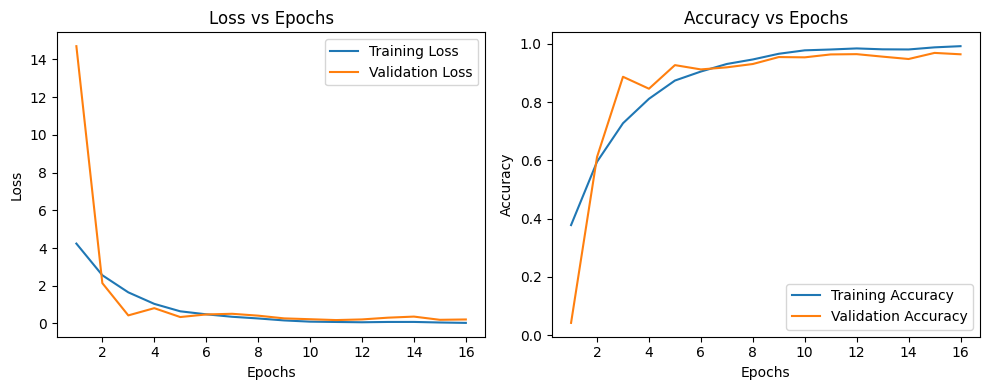

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint('best_custom_model.h5', save_best_only=True, verbose=1)
]

history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=callbacks
)

# Plotting Loss & Accuracy
epochs = range(1, len(history.history['loss']) + 1)

# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## VGG Transfer Learning

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Loading VGG16 without top classifier layers, using pretrained ImageNet weights
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base

# Getting class names from the 'train_dataset' object's parent directory
num_classes = len(os.listdir('/Users/farazahmed/Documents/Python projects/COMP534_assignment2/UCMerced_LandUse/UCMerced_LandUse/Images_jpg/augmented_dataset/trainval'))
vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Use num_classes
])

# Compiling model
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = vgg_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 108s 406ms/step - accuracy: 0.0772 - loss: 3.2935 - val_accuracy: 0.5290 - val_loss: 2.3651
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 112s 426ms/step - accuracy: 0.2787 - loss: 2.4287 - val_accuracy: 0.6752 - val_loss: 1.8304
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 135s 516ms/step - accuracy: 0.4357 - loss: 1.9420 - val_accuracy: 0.7433 - val_loss: 1.4716
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 144s 548ms/step - accuracy: 0.5147 - loss: 1.6432 - val_accuracy: 0.7614 - val_loss: 1.2416
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 539ms/step - accuracy: 0.5772 - loss: 1.4006 - val_accuracy: 0.7786 - val_loss: 1.0833
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 144s 547ms/step - accuracy: 0.6166 - loss: 1.2424 - val_accuracy: 0.7919 - val_loss: 0.9673
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 539ms/step - accuracy: 0.6532 - loss: 1.1352 - val_accuracy: 0.8019 - val_loss: 0.8765
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 145s 552ms/step - accuracy: 0.6874 -

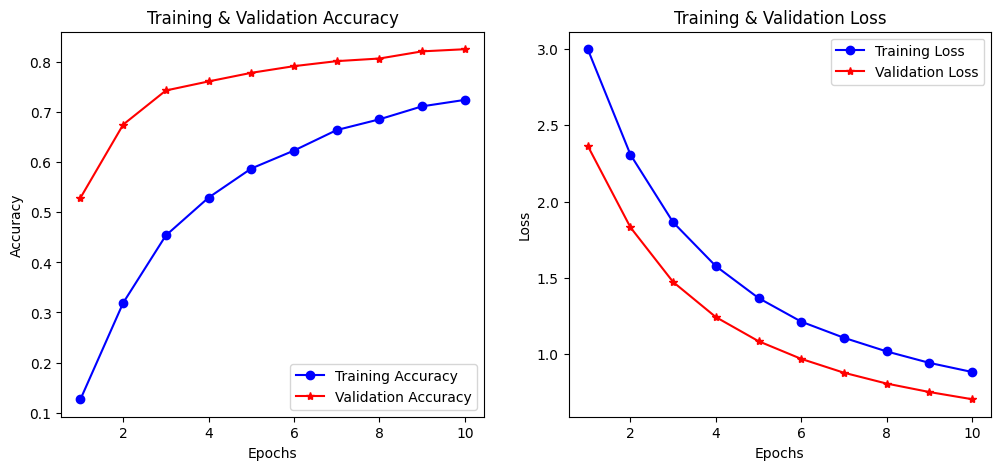

In [35]:
# Extracting history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [ ]:
vgg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,947,381 (15.06 MB)

 Trainable params: 3,945,365 (15.05 MB)

 Non-trainable params: 2,016 (7.88 KB)

## Fine Tuning VGG by unfreezing top 4 layers


In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Phase 1: Loading base model (frozen)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

# Adding custom head
num_classes = len(os.listdir('/Users/farazahmed/Documents/Python projects/COMP534_assignment2/UCMerced_LandUse/UCMerced_LandUse/Images_jpg/augmented_dataset/trainval'))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compiling & training head only
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Phase 2: Fine-tuning top layers of VGG16
# Unfreeze last 4 convolutional layers (or fine-tune more as needed)
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Optional: Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fine-tune the model
history_finetune = model.fit(train_dataset,
                             validation_data=val_dataset,
                             epochs=10,
                             callbacks=[early_stop])


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 105s 397ms/step - accuracy: 0.0638 - loss: 3.3585 - val_accuracy: 0.4862 - val_loss: 2.4261
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 109s 414ms/step - accuracy: 0.2532 - loss: 2.4914 - val_accuracy: 0.6533 - val_loss: 1.8454
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 125s 477ms/step - accuracy: 0.4128 - loss: 1.9659 - val_accuracy: 0.7290 - val_loss: 1.4792
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 131s 497ms/step - accuracy: 0.5230 - loss: 1.6128 - val_accuracy: 0.7690 - val_loss: 1.2384
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 131s 499ms/step - accuracy: 0.5822 - loss: 1.4044 - val_accuracy: 0.7886 - val_loss: 1.0768
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 134s 511ms/step - accuracy: 0.6072 - loss: 1.2639 - val_accuracy: 0.7895 - val_loss: 0.9587
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 135s 514ms/step - accuracy: 0.6645 - loss: 1.1204 - val_accuracy: 0.7995 - val_loss: 0.8714
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 134s 509ms/step - accuracy: 0.6868 -

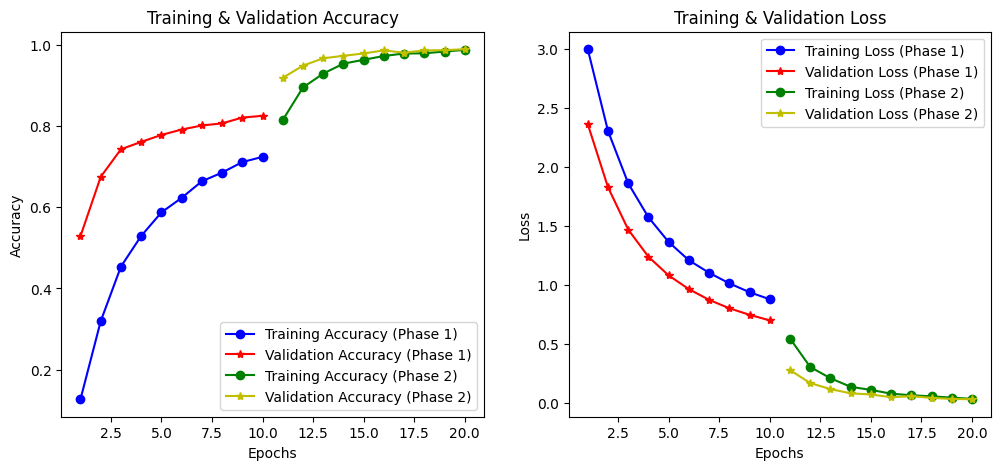

In [36]:
# Extract history for initial training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Extract history for fine-tuning
ft_acc = history_finetune.history['accuracy']
ft_val_acc = history_finetune.history['val_accuracy']
ft_loss = history_finetune.history['loss']
ft_val_loss = history_finetune.history['val_loss']
ft_epochs = range(len(acc) + 1, len(acc) + len(ft_acc) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy (Phase 1)')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy (Phase 1)')
plt.plot(ft_epochs, ft_acc, 'go-', label='Training Accuracy (Phase 2)')
plt.plot(ft_epochs, ft_val_acc, 'y*-', label='Validation Accuracy (Phase 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss (Phase 1)')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss (Phase 1)')
plt.plot(ft_epochs, ft_loss, 'go-', label='Training Loss (Phase 2)')
plt.plot(ft_epochs, ft_val_loss, 'y*-', label='Validation Loss (Phase 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

## Evaluating models


### Evaluating Custom Model

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9131 - loss: 0.6770
Test Loss: 1.1027
Test Accuracy: 0.8690
 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

2025-04-03 10:02:05.383881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.95      0.97        20
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00        20
           4       0.57      0.80      0.67        20
           5       1.00      1.00      1.00        20
           6       0.60      0.75      0.67        20
           7       1.00      1.00      1.00        20
           8       0.79      0.95      0.86        20
           9       0.81      0.85      0.83        20
          10       0.95      1.00      0.98        20
          11       0.86      0.90      0.88        20
          12       0.75      0.60      0.67        20
          13       0.94      0.80      0.86        20
          14       0.94      0.85      0.89        20
          15       1.00      0.85      0.92        20
          16       1.00      0.95      0.

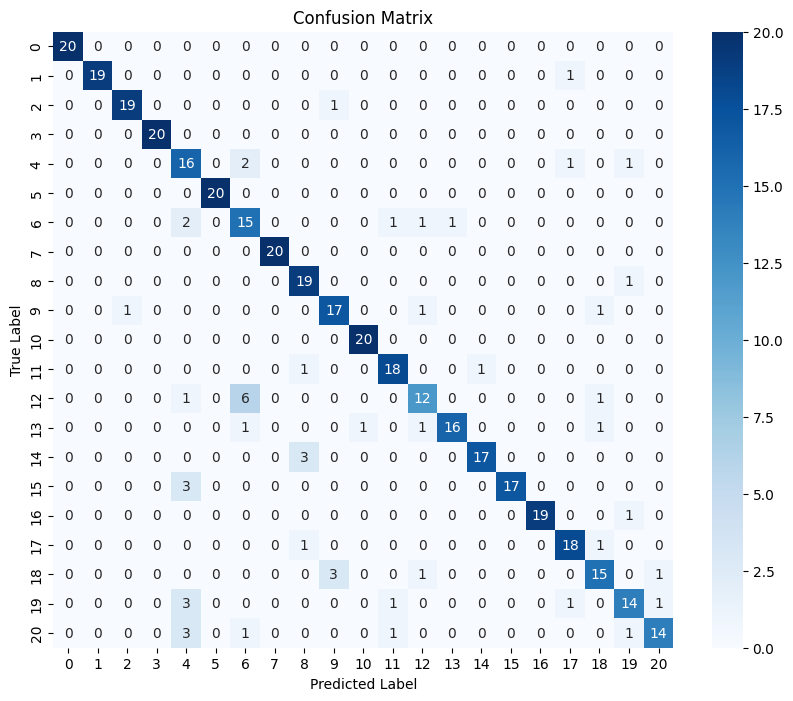

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate model on test dataset
test_loss, test_accuracy = custom_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred_probs = custom_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(21), yticklabels=range(21))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Evaluating VGG Transfer Learning

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.8456 - loss: 0.5827
Test Loss: 0.7228
Test Accuracy: 0.7952


2025-04-03 10:07:30.627652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.90      0.92        20
           2       0.86      0.90      0.88        20
           3       0.58      0.90      0.71        20
           4       0.76      0.65      0.70        20
           5       1.00      0.90      0.95        20
           6       0.75      0.45      0.56        20
           7       0.80      1.00      0.89        20
           8       0.70      0.95      0.81        20
           9       0.70      0.70      0.70        20
          10       1.00      1.00      1.00        20
          11       0.59      0.85      0.69        20
          12       0.60      0.75      0.67        20
          13       0.69      0.90      0.78        20
          14       0.90      0.95      0.93        20
          15       0.95      1.00      0.98        20
          16       0.62      0.50      0

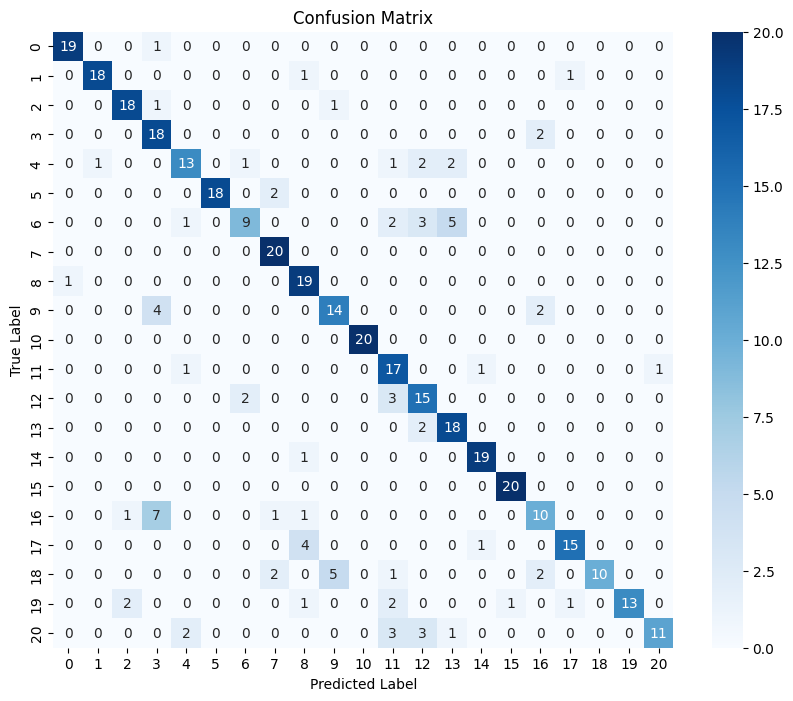

In [43]:
# Evaluating model on test dataset
test_loss, test_accuracy = vgg_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred_probs = vgg_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Evaluating Fine Tuned VGG (Best Model)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.9597 - loss: 0.1482
Test Loss: 0.2399
Test Accuracy: 0.9310


2025-04-03 10:07:02.087107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        20
           3       0.83      1.00      0.91        20
           4       0.95      0.90      0.92        20
           5       1.00      1.00      1.00        20
           6       0.72      0.90      0.80        20
           7       1.00      1.00      1.00        20
           8       0.83      1.00      0.91        20
           9       0.94      0.85      0.89        20
          10       1.00      1.00      1.00        20
          11       0.86      0.95      0.90        20
          12       0.83      0.75      0.79        20
          13       1.00      0.90      0.95        20
          14       0.91      1.00      0.95        20
          15       1.00      1.00      1.00        20
          16       0.89      0.85      0

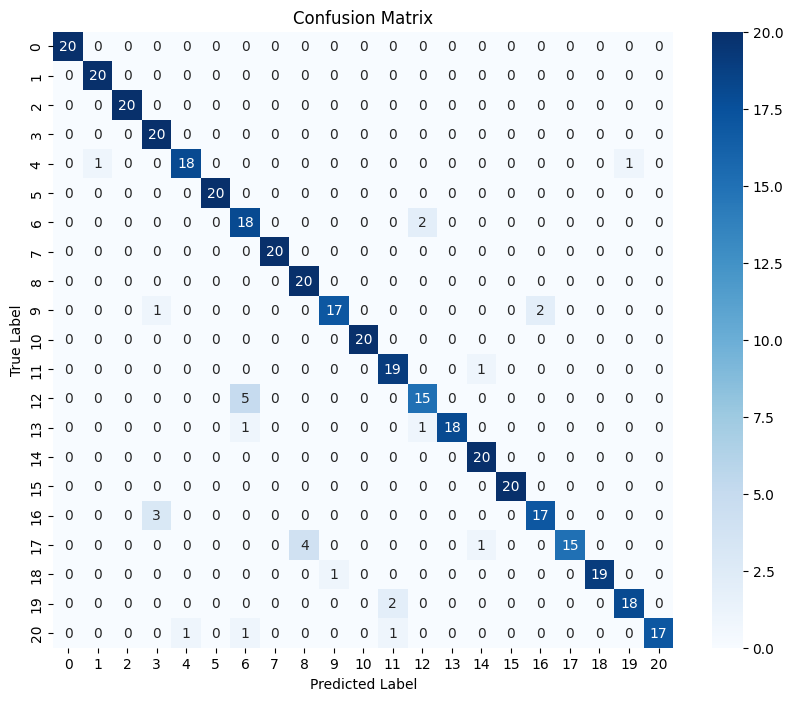

In [42]:
# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
